In [62]:
FTSZ_YTICKS = 13 #Colorbar + y on violin /hist
FTSZ_LABEL = 15 #Clumps + title of y for violin and colorbar
FTSZ_TITLE = 15 #(2 titles)
FTSZ_TOT = 15 #Total number of successes
FTSZ_COUNT = 12

In [63]:
from utils import flatten_list_of_list as flat
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import time
from matplotlib import gridspec
import matplotlib
from matplotlib.ticker import MaxNLocator
import os
from pathlib import Path
#Custom
import utils
import models
#KERAS
import tensorflow as tf
import keras
from tensorflow.keras.models import load_model
sns.set(font_scale=1)
def get_exps_dfs(fp_save,exp_names,file_names):
    #== Get path of save folder/ models and data
    n_exp = len(file_names)
    fp_runs_list = []
    fp_models_list = []
    for i in range(n_exp):
        save_folder = file_names[i]
        fp_runs_list.append(fp_save / Path(save_folder))
        fp_models_list.append(fp_save / Path(save_folder,'models'))
    #====Get params====
    dict_params_list = []
    for i in range(n_exp):
        fp_runs = fp_runs_list[i]
        with open(fp_runs /Path('dict_params.pickle'), 'rb') as handle:
            dict_params = pickle.load(handle)
            dict_params_list.append(dict_params)
    #display(pd.DataFrame(dict_params_list))
    df_params = pd.DataFrame(dict_params_list)
    ##========GET RESULTS==========
    df_all_res_list = []
    df_summary_res_list = []
    for i in range(n_exp):
        fp_runs = fp_runs_list[i]
        with open(str(fp_runs)+'/all_res.pickle', 'rb') as handle:
            all_res = pickle.load(handle)
        with open(str(fp_runs)+'/summary_res.pickle', 'rb') as handle:
            summary_res = pickle.load(handle)
            df_all_res = pd.DataFrame(utils.flatten_list_of_list(all_res))
            df_summary_res = pd.DataFrame(summary_res)
        df_all_res_list.append(df_all_res)
        df_summary_res_list.append(df_summary_res)
    df_all_res = pd.concat(df_all_res_list)
    df_summary_res = pd.concat(df_summary_res_list)
    #==Add columns for average accuracies to df_all_res
    df_all_res = add_avg_acc_columns(df_all_res)
    return df_all_res,df_summary_res, df_params
def add_avg_acc_columns(df_all_res):
    #==Add columns for average accuracies to df_all_res
    for s in ['1','5','10','half']:
        df_all_res['acc%s'%s] = 1/2 *(df_all_res['acc_f%s'%s]+df_all_res['acc_g%s'%s])
    return df_all_res
def get_exp_data_per_run(exp,df_epoch29_newfg,threshs,n_runs=10,n_restarts=100):
    df = utils.get_df(df_epoch29_newfg, exp = exp)
    #Loop through runs
    exp_data_per_run = np.zeros((n_runs,n_restarts))
    exp_n_good_per_run = np.zeros((n_runs,))
    for j in range(n_runs):
        thresh = threshs[j] #thresh for specific run
        df_run = utils.get_df(df, run = j)
        run_data =  np.array(list(df_run['acc1']))
        exp_data_per_run[j,:] = list(run_data) #1 row, 1 run. Transpose
        exp_n_good_per_run[j] = len(np.where(run_data>thresh)[0])
    return exp_data_per_run,exp_n_good_per_run
def get_exp_ceil_accs(exp,df_summary_res):
    df= utils.get_df(df_summary_res,exp=exp)
    ceil_accs = np.array(list(df['ceil_acc_1']))
    return ceil_accs
def get_useful_data_for_plotting(new_names,df_all_res,df_summary_res):
    '''
    Returns:
        all_exp_data (nexp,nruns,nrestart)
        all_ceil_accs (nexp,n_runs)
        n_good_per_run (nexp,n_runs)
    '''
    n_exp = len(new_names)
    #Filter df_all_res
    df_epoch29_newfg = utils.get_df(df_all_res, epoch=29, new_f=True, new_g=True)
    #Loop through exp
    all_ceil_accs = np.zeros((n_exp,10))
    n_good_per_run = np.zeros((n_exp,10)) #Each row is one exp
    all_exp_data = np.zeros((n_exp,10,100))
    for i in range(n_exp):
        exp = new_names[i]
        ceil_accs = get_exp_ceil_accs(exp,df_summary_res)
        threshs = 0.9*ceil_accs
        exp_data_per_run,exp_n_good_per_run = get_exp_data_per_run(exp,df_epoch29_newfg,threshs,n_runs=10,n_restarts=100)
        exp_data_all = exp_data_per_run.reshape(-1)
        #Store
        n_good_per_run[i,:] = exp_n_good_per_run
        all_ceil_accs[i,:]= ceil_accs
        all_exp_data[i,:,:] = exp_data_per_run
    return all_exp_data, all_ceil_accs,n_good_per_run
def get_dfs_from_key(key,dict_file_names,dict_exp_names,dict_new_names):
    file_names,exp_names,new_names = dict_file_names[key],dict_exp_names[key],dict_new_names[key]
    new_names = [n.replace(" \n (base)", "") for n in new_names]
    print(new_names)
    df_all_res,df_summary_res, df_params = get_exps_dfs(fp_save,exp_names,file_names)
#     for df in [df_all_res,df_summary_res, df_params]:
#             df["experiment_name"] = df["experiment_name"].replace(exp_names,new_names)
    return df_all_res,df_summary_res, df_params
def get_matches_data(scen,df_summary_res): #scen == exp == 'clump1'
    scen_matches_acc = list(df_summary_res[df_summary_res['experiment_name']==scen]['matches_acc'])
    scen_matches_acc = np.array(scen_matches_acc)
    avg_matches_acc= np.mean(scen_matches_acc)
    return avg_matches_acc,scen_matches_acc
def get_all_match_accs(new_names,df_all_res,df_summary_res):
    n_exp = len(new_names)
    all_match_accs = np.zeros((n_exp,10))
    n_exp = len(new_names)
    for i in range(n_exp):
        exp = new_names[i]
        _,match_accs = get_matches_data(exp,df_summary_res)
        all_match_accs[i,:] = match_accs
    return all_match_accs
def prefix(dic,pref):
    for key in dic:
        dic[key] = [pref+scen for scen in dic[key]]
    return dic

In [64]:
def outer_structure_match(n_exp,match_accs = True,bhist = False):
    wfig,hfig= min(n_exp/4 * 15,15), 4
    wr = 10* wfig/15 
    fig = plt.figure(figsize = (wfig,hfig)) 
    #==Split the grid
    #1 left 1 right
    outer_grid = gridspec.GridSpec(1,2,width_ratios=[wr, 1]) 
    outer_grid.update(wspace=0.15,hspace=0.5) 
    n_cols_bottom = 1 if not bhist else n_exp
    #Set up the left one (depends on if violin or hist) if hist only gs_bottom (1,n_exp)
    gs_left = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=outer_grid[0], height_ratios=[1e-1,1,1e-1,1,1e-1,7], hspace=0.4) #extra rows for titles
    gs_right = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=outer_grid[1],wspace=4)
    gs_toptop = gridspec.GridSpecFromSubplotSpec(1, n_exp, subplot_spec=gs_left[1])
    gs_top = gridspec.GridSpecFromSubplotSpec(1, n_exp, subplot_spec=gs_left[3])
    gs_bottom = gridspec.GridSpecFromSubplotSpec(1, n_cols_bottom, subplot_spec=gs_left[5])
    gs_toptop_title = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_left[0])
    gs_top_title = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_left[2])
    gs_bottom_title = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_left[4])
    #Set up axes to plot on
    axes_bottom = plt.subplot(gs_bottom[0]) if not bhist else [plt.subplot(gs_bottom[0,k]) for k in range(n_exp)]
    axes_runs = [plt.subplot(gs_top[0,k]) for k in range(n_exp)]
    axes_match = [plt.subplot(gs_toptop[0,k]) for k in range(n_exp)]
    ax_cb = plt.subplot(gs_right[0])
    ax_cb_match = plt.subplot(gs_right[1])
    #Some titles
    ax_toptop_title = plt.subplot(gs_toptop_title[0])
    ax_top_title = plt.subplot(gs_top_title[0])
    ax_bottom_title = plt.subplot(gs_bottom_title[0])
    ax_toptop_title.axis('off')
    ax_top_title.axis('off')
    ax_bottom_title.axis('off')
    ax_toptop_title.set_title("Surrogate accuracy per run",pad=-4,fontsize = FTSZ_TITLE)
    ax_top_title.set_title("Number of successful restart per run (1 cell per run)",pad=-4,fontsize = FTSZ_TITLE)
    ax_bottom_title.set_title("Accuracies and number of successful restart",pad = -7,fontsize = FTSZ_TITLE)
    return fig, axes_bottom, axes_runs, ax_cb , axes_match , ax_cb_match
#=== For both
def outer_structure(n_exp,bhist = False):
    wfig,hfig= min(n_exp/4 * 15,15), 4
    wr = 50* wfig/15 
    fig = plt.figure(figsize = (wfig,hfig)) 
    #==Split the grid
    #1 left 1 right
    outer_grid = gridspec.GridSpec(1,2,width_ratios=[wr, 1]) 
    outer_grid.update(wspace=0.15,hspace=0.5) 
    #Set up the left one (depends on if violin or hist) if hist only gs_bottom (1,n_exp)
    gs_left = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=outer_grid[0], height_ratios=[1e-1,1,1e-1,7], hspace=0.2) #extra rows for titles
    gs_right = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=outer_grid[1])
    n_cols_bottom = 1 if not bhist else n_exp
    gs_top = gridspec.GridSpecFromSubplotSpec(1, n_exp, subplot_spec=gs_left[1])
    gs_bottom = gridspec.GridSpecFromSubplotSpec(1, n_cols_bottom, subplot_spec=gs_left[3])
    gs_top_title = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_left[0])
    gs_bottom_title = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_left[2])
    #Set up axes to plot on
    axes_bottom = plt.subplot(gs_bottom[0]) if not bhist else [plt.subplot(gs_bottom[0,k]) for k in range(n_exp)]
    axes_runs = [plt.subplot(gs_top[0,k]) for k in range(n_exp)]
    ax_cb = plt.subplot(gs_right[0])
    #Some titles
    ax_top_title = plt.subplot(gs_top_title[0])
    ax_bottom_title = plt.subplot(gs_bottom_title[0])
    ax_top_title.axis('off')
    ax_bottom_title.axis('off')
    ax_top_title.set_title("Number of successful restart per run (1 cell per run)",pad=-4,fontsize = FTSZ_TITLE)
    ax_bottom_title.set_title("Accuracies and number of successful restart",pad = -7,fontsize = FTSZ_TITLE)
    return fig, axes_bottom, axes_runs, ax_cb
def plot_colorbar(ax,cf,title,max_val):
    ax.tick_params(axis=u'both', which=u'both',length=0, labelsize= FTSZ_YTICKS)
    ax.set_xlabel(title, rotation='vertical', fontsize=FTSZ_LABEL)
    ax.xaxis.set_label_coords(-0.9,3/4)
    cb = plt.colorbar(cf, cax=ax)
    cb.locator = MaxNLocator(integer=True)
    cb.update_ticks()
    if ax.get_xlim()[1]>max_val:
        ax.set_ylim(ymax=max_val)
        ax.set_xlim(xmax=max_val)
#=== VIOLIN
def plot_violin(ax,new_names,df_summary_res,df_all_res):
    df_epoch29_newfg = utils.get_df(df_all_res, epoch=29, new_f=True, new_g=True)
    sns.violinplot(x="experiment_name", y="acc1", data=df_epoch29_newfg,ax=ax, bw = 0.005, scale='count')
    ax.get_xaxis().get_label().set_vixible = False
    violin_add_ceil(ax,new_names,df_summary_res,df_all_res)
    ax.set_xlabel('')
    ax.set_ylabel('Top 1 accuracy', fontsize = FTSZ_LABEL)
    ax.tick_params(axis='x', which='major', labelsize=FTSZ_LABEL)
    ax.tick_params(axis='y', which='major', labelsize= FTSZ_YTICKS)
def plot_swarm(ax,df_all_res):
    df_epoch29_newfg = utils.get_df(df_all_res, epoch=29, new_f=True, new_g=True)
    sns.swarmplot(x="experiment_name", y="acc1", hue = 'run', data=df_epoch29_newfg,ax=ax,palette = 'dark')
#==Helpers
def violin_add_ceil(ax,new_names,df_summary_res,df_all_res):
    n_exp = len(new_names)
    #line/text coord
    xmins_lines,xmaxs_lines = violins_coord(n_exp)
    xmins_texts,xmaxs_texts = violins_coord(n_exp,ax)
    #Fetch useful data
    all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
    #Loop and add lines
    for i,exp in enumerate(new_names):
        #Fetch accuracy
        ceil_accs = all_ceil_accs[i]
        threshs_exp = 0.9 * ceil_accs
        tot_success = np.sum(n_good_per_run[i])
        #Val to plot
        ceil = np.mean(ceil_accs)
        thresh = 0.9*np.mean(ceil_accs)
        #plot lines
        ax.axhline(ceil, ls='--', color = 'k',xmin=xmins_lines[i], xmax=xmaxs_lines[i])
        ax.axhline(thresh, ls='--', color = 'k',xmin=xmins_lines[i], xmax=xmaxs_lines[i])
        #Plot text
        s = '%d'%tot_success
#         ax.text(xmaxs_texts[i],(ceil+thresh)/2,s,ha='left',va ='center',fontsize = FTSZ_TOT,fontweight = 'bold')
        ax.text(xmaxs_texts[i],thresh-0.01,s,ha='center',va ='top',fontsize = FTSZ_TOT,fontweight = 'bold')
def violins_coord(n_exp,ax=None):
    xlim0,xlim1 = (0,1) if ax is None else ax_violin.get_xlim() 
    totw = xlim1 - xlim0
    #settings
    step = 1/n_exp * totw
    w = 0.1 *totw
    centers = [xlim0+step*i+step/2 for i in range(n_exp)]
    xmins = [c-w/2 for c in centers]
    xmaxs = [c+w/2 for c in centers]    
    return xmins,xmaxs
#=== Run success
def get_run_success(axes,n_good_per_run,all_ceil_accs,cb_max_val = None):   
    mycmap = matplotlib.cm.get_cmap(COLOR)
    mycmap.set_under('k') #.set_bad('k')
    #Code
    n_exp = n_good_per_run.shape[0]
    n_runs = n_good_per_run.shape[1]
    max_val = np.max(n_good_per_run) + MARGIN if cb_max_val is None else cb_max_val
    for i in range(n_exp):
        Z = n_good_per_run[i][None,:]
        x = np.arange(0, n_runs+1, 1)  # len = 11
        y = np.arange(0, 2, 1)
        cf = axes[i].pcolormesh(x,y,Z, linewidths=0,cmap=mycmap,vmin=1, vmax=max_val) 
        #== y axis
        axes[i].yaxis.set_visible(False)
        #== x axis
        if i == 0:
            axes[i].yaxis.set_visible(True)
            axes[i].set_yticks([])
            xpos , ypos = -1,1           
        axes[i].set_xticks([]) 
    return cf #last plot
#Plot colormap matches accuracy
def plot_cm_match_accs(axes,all_match_accs):   
    mycmap = matplotlib.cm.get_cmap(COLOR)
    mycmap.set_under('k') #.set_bad('k')
    mycmap.set_over('w')
    #Code
    n_exp = all_match_accs.shape[0]
    n_runs = all_match_accs.shape[1]
    max_val = 1 + MARGIN_ACC #np.max(all_match_accs)
    for i in range(n_exp):
        Z = all_match_accs[i][None,:]
        x = np.arange(0, n_runs+1, 1)  # len = 11
        y = np.arange(0, 2, 1)
        cf = axes[i].pcolormesh(x,y,Z, linewidths=0,cmap=mycmap,vmin=0.01, vmax=max_val) 
        #== y axis
        axes[i].yaxis.set_visible(False)
        #== x axis
        if i == 0:
            axes[i].yaxis.set_visible(True)
            axes[i].set_yticks([])
            xpos , ypos = -1,1           
        axes[i].set_xticks([]) 
    return cf #last plot


In [65]:
fp_repo = "/Users/roseline/Docs/AI/GITHUB/unsupervised-alignment"
#fp_repo = '/content/gdrive/My Drive/unsupervised-alignment-team-master'
fp_intersect = fp_repo / Path('python','assets','intersect')
os.chdir(fp_repo / Path('python'))

# Import base

In [8]:
pref = ''
scen_folder = 'base_exp' #Folder in which all experiments are stored. 
#Dicts
dict_file_names = {}
dict_file_names['clump'] = flat([['base'],["clump%d"%i for i in range(2,8)]]) #base as has ceiling accuracy
dict_file_names['embdim'] = ['base',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_file_names['noise'] = ['base','noise0005','noise001','noise002']
dict_file_names['ncon'] = ['ncon50','ncon100','base','ncon300']
dict_file_names['all'] = ['base',"clump2","clump3","clump4","clump5","clump6","clump7"
                          ,"embdim3","embdim4","embdim5","embdim7","embdim10",
                         'noise0005','noise001','noise002',
                         'ncon50','ncon100','ncon300']
dict_file_names = prefix(dict_file_names,pref)
dict_exp_names = copy.deepcopy(dict_file_names) #Exp names if need to change
dict_new_names = copy.deepcopy(dict_exp_names)
#===Paths
fp_save = fp_repo / Path('save',scen_folder)

In [9]:
df_all_res_base,df_summary_res_base, df_params_base = get_dfs_from_key('all',dict_file_names,dict_exp_names,dict_new_names)
#=== Add matches acc 2
n_rows = len(df_summary_res_base)
df_summary_res_base['matches_acc'] = np.full((n_rows,),2)

['base', 'clump2', 'clump3', 'clump4', 'clump5', 'clump6', 'clump7', 'embdim3', 'embdim4', 'embdim5', 'embdim7', 'embdim10', 'noise0005', 'noise001', 'noise002', 'ncon50', 'ncon100', 'ncon300']


In [10]:
#GEt ALL ALL DATA
exceptions = ['all'] 
all_n_good_per_run = []
all_labels = []
for key in dict_file_names:    
    if key not in exceptions:
        #==Get files and data
        df_all_res,df_summary_res, df_params = get_dfs_from_key(key,dict_file_names,dict_exp_names,dict_new_names)
        new_names = dict_exp_names[key]
        all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
        all_n_good_per_run.append(n_good_per_run)
all_labels = flat(all_labels)        
all_n_good_per_run = np.concatenate(all_n_good_per_run,axis = 0)
print(all_n_good_per_run.shape)
all_n_good_per_run_base = all_n_good_per_run

['base', 'clump2', 'clump3', 'clump4', 'clump5', 'clump6', 'clump7']
['base', 'embdim3', 'embdim4', 'embdim5', 'embdim7', 'embdim10']
['base', 'noise0005', 'noise001', 'noise002']
['ncon50', 'ncon100', 'base', 'ncon300']
(21, 10)


# Import dist Ncorr3

In [66]:
pref = 'knn_pretrain_dist_Ncorr3_'
scen_folder = 'knn_pretrain_dist_Ncorr3' #Folder in which all experiments are stored. 
#Dicts
dict_file_names = {}
dict_file_names['clump'] = flat([['base'],["clump%d"%i for i in range(2,8)]]) #base as has ceiling accuracy
dict_file_names['embdim'] = ['base',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_file_names['noise'] = ['base','noise5e-3','noise1e-2','noise2e-2']
dict_file_names['ncon'] = ['ncon50','ncon100','base','ncon300']
dict_file_names['all'] = ['base',"clump2","clump3","clump4","clump5","clump6","clump7"
                          ,"embdim3","embdim4","embdim5","embdim7","embdim10",
                         'noise5e-3','noise1e-2','noise2e-2',
                         'ncon50','ncon100','ncon300']
dict_file_names = prefix(dict_file_names,pref)
dict_exp_names = copy.deepcopy(dict_file_names) #Exp names if need to change
dict_new_names = copy.deepcopy(dict_exp_names)
#===Paths
fp_save = fp_repo / Path('save',scen_folder)

In [67]:
df_all_res_dist_Ncorr3,df_summary_res_dist_Ncorr3, df_params_dist_Ncorr3 = get_dfs_from_key('all',dict_file_names,dict_exp_names,dict_new_names)

['knn_pretrain_dist_Ncorr3_base', 'knn_pretrain_dist_Ncorr3_clump2', 'knn_pretrain_dist_Ncorr3_clump3', 'knn_pretrain_dist_Ncorr3_clump4', 'knn_pretrain_dist_Ncorr3_clump5', 'knn_pretrain_dist_Ncorr3_clump6', 'knn_pretrain_dist_Ncorr3_clump7', 'knn_pretrain_dist_Ncorr3_embdim3', 'knn_pretrain_dist_Ncorr3_embdim4', 'knn_pretrain_dist_Ncorr3_embdim5', 'knn_pretrain_dist_Ncorr3_embdim7', 'knn_pretrain_dist_Ncorr3_embdim10', 'knn_pretrain_dist_Ncorr3_noise5e-3', 'knn_pretrain_dist_Ncorr3_noise1e-2', 'knn_pretrain_dist_Ncorr3_noise2e-2', 'knn_pretrain_dist_Ncorr3_ncon50', 'knn_pretrain_dist_Ncorr3_ncon100', 'knn_pretrain_dist_Ncorr3_ncon300']


In [68]:
#GEt ALL ALL DATA
exceptions = ['all'] 
all_n_good_per_run = []
all_all_match_accs = []
all_labels = []
for key in dict_file_names:    
    if key not in exceptions:
        #==Get files and data
        df_all_res,df_summary_res, df_params = get_dfs_from_key(key,dict_file_names,dict_exp_names,dict_new_names)
        new_names = dict_exp_names[key]
        all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
        all_n_good_per_run.append(n_good_per_run)
        all_match_accs = get_all_match_accs(new_names,df_all_res,df_summary_res)
        all_all_match_accs.append(all_match_accs)
all_labels = flat(all_labels)        
all_n_good_per_run = np.concatenate(all_n_good_per_run,axis = 0)
all_all_match_accs = np.concatenate(all_all_match_accs,axis = 0)
print(all_n_good_per_run.shape)
all_all_match_accs_dist_Ncorr3 = all_all_match_accs
all_n_good_per_run_dist_Ncorr3 = all_n_good_per_run

['knn_pretrain_dist_Ncorr3_base', 'knn_pretrain_dist_Ncorr3_clump2', 'knn_pretrain_dist_Ncorr3_clump3', 'knn_pretrain_dist_Ncorr3_clump4', 'knn_pretrain_dist_Ncorr3_clump5', 'knn_pretrain_dist_Ncorr3_clump6', 'knn_pretrain_dist_Ncorr3_clump7']
['knn_pretrain_dist_Ncorr3_base', 'knn_pretrain_dist_Ncorr3_embdim3', 'knn_pretrain_dist_Ncorr3_embdim4', 'knn_pretrain_dist_Ncorr3_embdim5', 'knn_pretrain_dist_Ncorr3_embdim7', 'knn_pretrain_dist_Ncorr3_embdim10']
['knn_pretrain_dist_Ncorr3_base', 'knn_pretrain_dist_Ncorr3_noise5e-3', 'knn_pretrain_dist_Ncorr3_noise1e-2', 'knn_pretrain_dist_Ncorr3_noise2e-2']
['knn_pretrain_dist_Ncorr3_ncon50', 'knn_pretrain_dist_Ncorr3_ncon100', 'knn_pretrain_dist_Ncorr3_base', 'knn_pretrain_dist_Ncorr3_ncon300']
(21, 10)


# Import dist

In [69]:
pref = 'knn_pretrain_dist_'
scen_folder = 'knn_pretrain_dist' #Folder in which all experiments are stored. 
#Dicts
dict_file_names = {}
dict_file_names['clump'] = flat([['base'],["clump%d"%i for i in range(2,8)]]) #base as has ceiling accuracy
dict_file_names['embdim'] = ['base',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_file_names['noise'] = ['base','noise5e-3','noise1e-2','noise2e-2']
dict_file_names['ncon'] = ['ncon50','ncon100','base','ncon300']
dict_file_names['all'] = ['base',"clump2","clump3","clump4","clump5","clump6","clump7"
                          ,"embdim3","embdim4","embdim5","embdim7","embdim10",
                         'noise5e-3','noise1e-2','noise2e-2',
                         'ncon50','ncon100','ncon300']
dict_file_names = prefix(dict_file_names,pref)
dict_exp_names = copy.deepcopy(dict_file_names) #Exp names if need to change
dict_new_names = copy.deepcopy(dict_exp_names)
#===Paths
fp_save = fp_repo / Path('save',scen_folder)

In [70]:
df_all_res_dist,df_summary_res_dist, df_params_dist = get_dfs_from_key('all',dict_file_names,dict_exp_names,dict_new_names)

['knn_pretrain_dist_base', 'knn_pretrain_dist_clump2', 'knn_pretrain_dist_clump3', 'knn_pretrain_dist_clump4', 'knn_pretrain_dist_clump5', 'knn_pretrain_dist_clump6', 'knn_pretrain_dist_clump7', 'knn_pretrain_dist_embdim3', 'knn_pretrain_dist_embdim4', 'knn_pretrain_dist_embdim5', 'knn_pretrain_dist_embdim7', 'knn_pretrain_dist_embdim10', 'knn_pretrain_dist_noise5e-3', 'knn_pretrain_dist_noise1e-2', 'knn_pretrain_dist_noise2e-2', 'knn_pretrain_dist_ncon50', 'knn_pretrain_dist_ncon100', 'knn_pretrain_dist_ncon300']


In [75]:
#GEt ALL ALL DATA
exceptions = ['all'] 
all_n_good_per_run = []
all_all_match_accs = []
all_labels = []
for key in dict_file_names:    
    if key not in exceptions:
        #==Get files and data
        df_all_res,df_summary_res, df_params = get_dfs_from_key(key,dict_file_names,dict_exp_names,dict_new_names)
        new_names = dict_exp_names[key]
        all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
        all_n_good_per_run.append(n_good_per_run)
        all_match_accs = get_all_match_accs(new_names,df_all_res,df_summary_res)
        all_all_match_accs.append(all_match_accs)
all_labels = flat(all_labels)        
all_n_good_per_run = np.concatenate(all_n_good_per_run,axis = 0)
all_all_match_accs = np.concatenate(all_all_match_accs,axis = 0)
print(all_n_good_per_run.shape)
all_all_match_accs_dist = all_all_match_accs
all_n_good_per_run_dist = all_n_good_per_run

['knn_pretrain_dist_base', 'knn_pretrain_dist_clump2', 'knn_pretrain_dist_clump3', 'knn_pretrain_dist_clump4', 'knn_pretrain_dist_clump5', 'knn_pretrain_dist_clump6', 'knn_pretrain_dist_clump7']
['knn_pretrain_dist_base', 'knn_pretrain_dist_embdim3', 'knn_pretrain_dist_embdim4', 'knn_pretrain_dist_embdim5', 'knn_pretrain_dist_embdim7', 'knn_pretrain_dist_embdim10']
['knn_pretrain_dist_base', 'knn_pretrain_dist_noise5e-3', 'knn_pretrain_dist_noise1e-2', 'knn_pretrain_dist_noise2e-2']
['knn_pretrain_dist_ncon50', 'knn_pretrain_dist_ncon100', 'knn_pretrain_dist_base', 'knn_pretrain_dist_ncon300']
(21, 10)


# angles k

In [17]:
# Import angles k
pref = 'knn_pretrain_angles_k_'
scen_folder = 'knn_pretrain_angles_k' #Folder in which all experiments are stored. 
#Dicts
dict_file_names = {}
dict_file_names['clump'] = flat([['base'],["clump%d"%i for i in range(2,8)]]) #base as has ceiling accuracy
dict_file_names['embdim'] = ['base',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_file_names['noise'] = ['base','noise5e-3','noise1e-2','noise2e-2']
dict_file_names['ncon'] = ['ncon50','ncon100','base','ncon300']
dict_file_names['all'] = ['base',"clump2","clump3","clump4","clump5","clump6","clump7"
                          ,"embdim3","embdim4","embdim5","embdim7","embdim10",
                         'noise5e-3','noise1e-2','noise2e-2',
                         'ncon50','ncon100','ncon300']
dict_file_names = prefix(dict_file_names,pref)
dict_exp_names = copy.deepcopy(dict_file_names) #Exp names if need to change
dict_new_names = copy.deepcopy(dict_exp_names)
#===Paths
fp_save = fp_repo / Path('save',scen_folder)

In [18]:
df_all_res_angles_k,df_summary_res_angles_k, df_params_angles_k = get_dfs_from_key('all',dict_file_names,dict_exp_names,dict_new_names)

['knn_pretrain_angles_k_base', 'knn_pretrain_angles_k_clump2', 'knn_pretrain_angles_k_clump3', 'knn_pretrain_angles_k_clump4', 'knn_pretrain_angles_k_clump5', 'knn_pretrain_angles_k_clump6', 'knn_pretrain_angles_k_clump7', 'knn_pretrain_angles_k_embdim3', 'knn_pretrain_angles_k_embdim4', 'knn_pretrain_angles_k_embdim5', 'knn_pretrain_angles_k_embdim7', 'knn_pretrain_angles_k_embdim10', 'knn_pretrain_angles_k_noise5e-3', 'knn_pretrain_angles_k_noise1e-2', 'knn_pretrain_angles_k_noise2e-2', 'knn_pretrain_angles_k_ncon50', 'knn_pretrain_angles_k_ncon100', 'knn_pretrain_angles_k_ncon300']


In [19]:
#GEt ALL ALL DATA
exceptions = ['all'] 
all_n_good_per_run = []
all_all_match_accs = []
all_labels = []
for key in dict_file_names:    
    if key not in exceptions:
        #==Get files and data
        df_all_res,df_summary_res, df_params = get_dfs_from_key(key,dict_file_names,dict_exp_names,dict_new_names)
        new_names = dict_exp_names[key]
        all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
        all_n_good_per_run.append(n_good_per_run)
        all_match_accs = get_all_match_accs(new_names,df_all_res,df_summary_res)
        all_all_match_accs.append(all_match_accs)
all_labels = flat(all_labels)        
all_n_good_per_run = np.concatenate(all_n_good_per_run,axis = 0)
all_all_match_accs = np.concatenate(all_all_match_accs,axis = 0)
print(all_n_good_per_run.shape)
all_all_match_accs_dist_angles_k = all_all_match_accs
all_n_good_per_run_dist_angles_k = all_n_good_per_run

['knn_pretrain_angles_k_base', 'knn_pretrain_angles_k_clump2', 'knn_pretrain_angles_k_clump3', 'knn_pretrain_angles_k_clump4', 'knn_pretrain_angles_k_clump5', 'knn_pretrain_angles_k_clump6', 'knn_pretrain_angles_k_clump7']
['knn_pretrain_angles_k_base', 'knn_pretrain_angles_k_embdim3', 'knn_pretrain_angles_k_embdim4', 'knn_pretrain_angles_k_embdim5', 'knn_pretrain_angles_k_embdim7', 'knn_pretrain_angles_k_embdim10']
['knn_pretrain_angles_k_base', 'knn_pretrain_angles_k_noise5e-3', 'knn_pretrain_angles_k_noise1e-2', 'knn_pretrain_angles_k_noise2e-2']
['knn_pretrain_angles_k_ncon50', 'knn_pretrain_angles_k_ncon100', 'knn_pretrain_angles_k_base', 'knn_pretrain_angles_k_ncon300']
(21, 10)


# Get radius

In [20]:
pref = 'knn_pretrain_angles_radius_'
scen_folder = 'knn_pretrain_angles_radius_fixed' #Folder in which all experiments are stored. 
#Dicts
dict_file_names = {}
dict_file_names['clump'] = flat([['base'],["clump%d"%i for i in range(2,8)]]) #base as has ceiling accuracy
dict_file_names['embdim'] = ['base',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_file_names['noise'] = ['base','noise5e-3','noise001','noise2e-2']
dict_file_names['ncon'] = ['ncon50','ncon100','base','ncon300']
dict_file_names['all'] = ['base',"clump2","clump3","clump4","clump5","clump6","clump7"
                          ,"embdim3","embdim4","embdim5","embdim7","embdim10",
                         'noise5e-3','noise001','noise2e-2',
                         'ncon50','ncon100','ncon300']
dict_file_names = prefix(dict_file_names,pref)
dict_exp_names = copy.deepcopy(dict_file_names) #Exp names if need to change
dict_new_names = copy.deepcopy(dict_exp_names)
#===Paths
fp_save = fp_repo / Path('save',scen_folder)
os.chdir(fp_repo / Path('python'))

In [21]:
df_all_res_angles_rad,df_summary_res_angles_rad, df_params_angles_rad = get_dfs_from_key('all',dict_file_names,dict_exp_names,dict_new_names)


['knn_pretrain_angles_radius_base', 'knn_pretrain_angles_radius_clump2', 'knn_pretrain_angles_radius_clump3', 'knn_pretrain_angles_radius_clump4', 'knn_pretrain_angles_radius_clump5', 'knn_pretrain_angles_radius_clump6', 'knn_pretrain_angles_radius_clump7', 'knn_pretrain_angles_radius_embdim3', 'knn_pretrain_angles_radius_embdim4', 'knn_pretrain_angles_radius_embdim5', 'knn_pretrain_angles_radius_embdim7', 'knn_pretrain_angles_radius_embdim10', 'knn_pretrain_angles_radius_noise5e-3', 'knn_pretrain_angles_radius_noise001', 'knn_pretrain_angles_radius_noise2e-2', 'knn_pretrain_angles_radius_ncon50', 'knn_pretrain_angles_radius_ncon100', 'knn_pretrain_angles_radius_ncon300']


In [22]:
#GEt ALL ALL DATA
exceptions = ['all'] 
all_all_match_accs = []
all_n_good_per_run = []
all_labels = []
for key in dict_file_names:    
    if key not in exceptions:
        #==Get files and data
        df_all_res,df_summary_res, df_params = get_dfs_from_key(key,dict_file_names,dict_exp_names,dict_new_names)
        new_names = dict_exp_names[key]
        all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
        all_n_good_per_run.append(n_good_per_run)
        all_match_accs = get_all_match_accs(new_names,df_all_res,df_summary_res)
        all_all_match_accs.append(all_match_accs)
all_labels = flat(all_labels)        
all_n_good_per_run = np.concatenate(all_n_good_per_run,axis = 0)
all_all_match_accs = np.concatenate(all_all_match_accs,axis = 0)
print(all_n_good_per_run.shape)
all_all_match_accs_dist_angles_rad = all_all_match_accs
all_n_good_per_run_dist_angles_rad = all_n_good_per_run

['knn_pretrain_angles_radius_base', 'knn_pretrain_angles_radius_clump2', 'knn_pretrain_angles_radius_clump3', 'knn_pretrain_angles_radius_clump4', 'knn_pretrain_angles_radius_clump5', 'knn_pretrain_angles_radius_clump6', 'knn_pretrain_angles_radius_clump7']
['knn_pretrain_angles_radius_base', 'knn_pretrain_angles_radius_embdim3', 'knn_pretrain_angles_radius_embdim4', 'knn_pretrain_angles_radius_embdim5', 'knn_pretrain_angles_radius_embdim7', 'knn_pretrain_angles_radius_embdim10']
['knn_pretrain_angles_radius_base', 'knn_pretrain_angles_radius_noise5e-3', 'knn_pretrain_angles_radius_noise001', 'knn_pretrain_angles_radius_noise2e-2']
['knn_pretrain_angles_radius_ncon50', 'knn_pretrain_angles_radius_ncon100', 'knn_pretrain_angles_radius_base', 'knn_pretrain_angles_radius_ncon300']
(21, 10)


# Get dist best k

In [23]:
pref = 'knn_pretrain_dist_bestk_'
scen_folder = 'knn_pretrain_dist_bestk' #Folder in which all experiments are stored. 
#Dicts
dict_file_names = {}
dict_file_names['clump'] = flat([['base'],["clump%d"%i for i in range(2,8)]]) #base as has ceiling accuracy
dict_file_names['embdim'] = ['base',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_file_names['noise'] = ['base','noise5e-3','noise1e-2','noise2e-2']
dict_file_names['ncon'] = ['ncon50','ncon100','base','ncon300']
dict_file_names['all'] = ['base',"clump2","clump3","clump4","clump5","clump6","clump7"
                          ,"embdim3","embdim4","embdim5","embdim7","embdim10",
                         'noise5e-3','noise1e-2','noise2e-2',
                         'ncon50','ncon100','ncon300']
dict_file_names = prefix(dict_file_names,pref)
dict_exp_names = copy.deepcopy(dict_file_names) #Exp names if need to change
dict_new_names = copy.deepcopy(dict_exp_names)
#===Paths
fp_save = fp_repo / Path('save',scen_folder)

In [24]:
df_all_res_dist_k_best,df_summary_res_dist_k_best, df_params_dist_k_best = get_dfs_from_key('all',dict_file_names,dict_exp_names,dict_new_names)

['knn_pretrain_dist_bestk_base', 'knn_pretrain_dist_bestk_clump2', 'knn_pretrain_dist_bestk_clump3', 'knn_pretrain_dist_bestk_clump4', 'knn_pretrain_dist_bestk_clump5', 'knn_pretrain_dist_bestk_clump6', 'knn_pretrain_dist_bestk_clump7', 'knn_pretrain_dist_bestk_embdim3', 'knn_pretrain_dist_bestk_embdim4', 'knn_pretrain_dist_bestk_embdim5', 'knn_pretrain_dist_bestk_embdim7', 'knn_pretrain_dist_bestk_embdim10', 'knn_pretrain_dist_bestk_noise5e-3', 'knn_pretrain_dist_bestk_noise1e-2', 'knn_pretrain_dist_bestk_noise2e-2', 'knn_pretrain_dist_bestk_ncon50', 'knn_pretrain_dist_bestk_ncon100', 'knn_pretrain_dist_bestk_ncon300']


In [25]:
#GEt ALL ALL DATA
exceptions = ['all'] 
all_all_match_accs = []
all_n_good_per_run = []
all_labels = []
for key in dict_file_names:    
    if key not in exceptions:
        #==Get files and data
        df_all_res,df_summary_res, df_params = get_dfs_from_key(key,dict_file_names,dict_exp_names,dict_new_names)
        new_names = dict_exp_names[key]
        all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
        all_n_good_per_run.append(n_good_per_run)
        all_match_accs = get_all_match_accs(new_names,df_all_res,df_summary_res)
        all_all_match_accs.append(all_match_accs)
all_labels = flat(all_labels)        
all_n_good_per_run = np.concatenate(all_n_good_per_run,axis = 0)
all_all_match_accs = np.concatenate(all_all_match_accs,axis = 0)
print(all_n_good_per_run.shape)
all_all_match_accs_dist_best = all_all_match_accs
all_n_good_per_run_dist_best = all_n_good_per_run

['knn_pretrain_dist_bestk_base', 'knn_pretrain_dist_bestk_clump2', 'knn_pretrain_dist_bestk_clump3', 'knn_pretrain_dist_bestk_clump4', 'knn_pretrain_dist_bestk_clump5', 'knn_pretrain_dist_bestk_clump6', 'knn_pretrain_dist_bestk_clump7']
['knn_pretrain_dist_bestk_base', 'knn_pretrain_dist_bestk_embdim3', 'knn_pretrain_dist_bestk_embdim4', 'knn_pretrain_dist_bestk_embdim5', 'knn_pretrain_dist_bestk_embdim7', 'knn_pretrain_dist_bestk_embdim10']
['knn_pretrain_dist_bestk_base', 'knn_pretrain_dist_bestk_noise5e-3', 'knn_pretrain_dist_bestk_noise1e-2', 'knn_pretrain_dist_bestk_noise2e-2']
['knn_pretrain_dist_bestk_ncon50', 'knn_pretrain_dist_bestk_ncon100', 'knn_pretrain_dist_bestk_base', 'knn_pretrain_dist_bestk_ncon300']
(21, 10)


# Get angles best k

In [26]:
pref = 'knn_pretrain_angles_k_best_'
scen_folder = 'knn_pretrain_angles_k_best' #Folder in which all experiments are stored. 
#Dicts
dict_file_names = {}
dict_file_names['clump'] = flat([['base'],["clump%d"%i for i in range(2,8)]]) #base as has ceiling accuracy
dict_file_names['embdim'] = ['base',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_file_names['noise'] = ['base','noise5e-3','noise1e-2','noise2e-2']
dict_file_names['ncon'] = ['ncon50','ncon100','base','ncon300']
dict_file_names['all'] = ['base',"clump2","clump3","clump4","clump5","clump6","clump7"
                          ,"embdim3","embdim4","embdim5","embdim7","embdim10",
                         'noise5e-3','noise1e-2','noise2e-2',
                         'ncon50','ncon100','ncon300']
dict_file_names = prefix(dict_file_names,pref)
dict_exp_names = copy.deepcopy(dict_file_names) #Exp names if need to change
dict_new_names = copy.deepcopy(dict_exp_names)
#===Paths
fp_save = fp_repo / Path('save',scen_folder)

In [27]:
df_all_res_angles_k_best,df_summary_res_angles_k_best, df_params_angles_k_best = get_dfs_from_key('all',dict_file_names,dict_exp_names,dict_new_names)

['knn_pretrain_angles_k_best_base', 'knn_pretrain_angles_k_best_clump2', 'knn_pretrain_angles_k_best_clump3', 'knn_pretrain_angles_k_best_clump4', 'knn_pretrain_angles_k_best_clump5', 'knn_pretrain_angles_k_best_clump6', 'knn_pretrain_angles_k_best_clump7', 'knn_pretrain_angles_k_best_embdim3', 'knn_pretrain_angles_k_best_embdim4', 'knn_pretrain_angles_k_best_embdim5', 'knn_pretrain_angles_k_best_embdim7', 'knn_pretrain_angles_k_best_embdim10', 'knn_pretrain_angles_k_best_noise5e-3', 'knn_pretrain_angles_k_best_noise1e-2', 'knn_pretrain_angles_k_best_noise2e-2', 'knn_pretrain_angles_k_best_ncon50', 'knn_pretrain_angles_k_best_ncon100', 'knn_pretrain_angles_k_best_ncon300']


In [28]:
#GEt ALL ALL DATA
exceptions = ['all'] 
all_n_good_per_run = []
all_all_match_accs = []
all_labels = []
for key in dict_file_names:    
    if key not in exceptions:
        #==Get files and data
        df_all_res,df_summary_res, df_params = get_dfs_from_key(key,dict_file_names,dict_exp_names,dict_new_names)
        new_names = dict_exp_names[key]
        all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
        all_n_good_per_run.append(n_good_per_run)
        all_match_accs = get_all_match_accs(new_names,df_all_res,df_summary_res)
        all_all_match_accs.append(all_match_accs)
all_labels = flat(all_labels)        
all_n_good_per_run = np.concatenate(all_n_good_per_run,axis = 0)
all_all_match_accs = np.concatenate(all_all_match_accs,axis = 0)
print(all_n_good_per_run.shape)
all_all_match_accs_angles_k_best = all_all_match_accs
all_n_good_per_run_angles_k_best = all_n_good_per_run

['knn_pretrain_angles_k_best_base', 'knn_pretrain_angles_k_best_clump2', 'knn_pretrain_angles_k_best_clump3', 'knn_pretrain_angles_k_best_clump4', 'knn_pretrain_angles_k_best_clump5', 'knn_pretrain_angles_k_best_clump6', 'knn_pretrain_angles_k_best_clump7']
['knn_pretrain_angles_k_best_base', 'knn_pretrain_angles_k_best_embdim3', 'knn_pretrain_angles_k_best_embdim4', 'knn_pretrain_angles_k_best_embdim5', 'knn_pretrain_angles_k_best_embdim7', 'knn_pretrain_angles_k_best_embdim10']
['knn_pretrain_angles_k_best_base', 'knn_pretrain_angles_k_best_noise5e-3', 'knn_pretrain_angles_k_best_noise1e-2', 'knn_pretrain_angles_k_best_noise2e-2']
['knn_pretrain_angles_k_best_ncon50', 'knn_pretrain_angles_k_best_ncon100', 'knn_pretrain_angles_k_best_base', 'knn_pretrain_angles_k_best_ncon300']
(21, 10)


# Get best rad

In [29]:
pref = 'knn_pretrain_angles_radius_best_'
scen_folder = 'knn_pretrain_angles_radius_best' #Folder in which all experiments are stored. 
#Dicts
dict_file_names = {}
dict_file_names['clump'] = flat([['base'],["clump%d"%i for i in range(2,8)]]) #base as has ceiling accuracy
dict_file_names['embdim'] = ['base',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_file_names['noise'] = ['base','noise5e-3','noise1e-2','noise2e-2']
dict_file_names['ncon'] = ['ncon50','ncon100','base','ncon300']
dict_file_names['all'] = ['base',"clump2","clump3","clump4","clump5","clump6","clump7"
                          ,"embdim3","embdim4","embdim5","embdim7","embdim10",
                         'noise5e-3','noise1e-2','noise2e-2',
                         'ncon50','ncon100','ncon300']
dict_file_names = prefix(dict_file_names,pref)
dict_exp_names = copy.deepcopy(dict_file_names) #Exp names if need to change
dict_new_names = copy.deepcopy(dict_exp_names)
#===Paths
fp_save = fp_repo / Path('save',scen_folder)

In [30]:
df_all_res_angles_rad_best,df_summary_res_angles_rad_best, df_params_angles_rad_best = get_dfs_from_key('all',dict_file_names,dict_exp_names,dict_new_names)

['knn_pretrain_angles_radius_best_base', 'knn_pretrain_angles_radius_best_clump2', 'knn_pretrain_angles_radius_best_clump3', 'knn_pretrain_angles_radius_best_clump4', 'knn_pretrain_angles_radius_best_clump5', 'knn_pretrain_angles_radius_best_clump6', 'knn_pretrain_angles_radius_best_clump7', 'knn_pretrain_angles_radius_best_embdim3', 'knn_pretrain_angles_radius_best_embdim4', 'knn_pretrain_angles_radius_best_embdim5', 'knn_pretrain_angles_radius_best_embdim7', 'knn_pretrain_angles_radius_best_embdim10', 'knn_pretrain_angles_radius_best_noise5e-3', 'knn_pretrain_angles_radius_best_noise1e-2', 'knn_pretrain_angles_radius_best_noise2e-2', 'knn_pretrain_angles_radius_best_ncon50', 'knn_pretrain_angles_radius_best_ncon100', 'knn_pretrain_angles_radius_best_ncon300']


In [31]:
#GEt ALL ALL DATA
exceptions = ['all'] 
all_n_good_per_run = []
all_all_match_accs = []
all_labels = []
for key in dict_file_names:    
    if key not in exceptions:
        #==Get files and data
        df_all_res,df_summary_res, df_params = get_dfs_from_key(key,dict_file_names,dict_exp_names,dict_new_names)
        new_names = dict_exp_names[key]
        all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(new_names,df_all_res,df_summary_res)
        all_n_good_per_run.append(n_good_per_run)
        all_match_accs = get_all_match_accs(new_names,df_all_res,df_summary_res)
        all_all_match_accs.append(all_match_accs)
all_labels = flat(all_labels)        
all_n_good_per_run = np.concatenate(all_n_good_per_run,axis = 0)
all_all_match_accs = np.concatenate(all_all_match_accs,axis = 0)
print(all_n_good_per_run.shape)
all_all_match_accs_angles_rad_best = all_all_match_accs
all_n_good_per_run_angles_rad_best = all_n_good_per_run

['knn_pretrain_angles_radius_best_base', 'knn_pretrain_angles_radius_best_clump2', 'knn_pretrain_angles_radius_best_clump3', 'knn_pretrain_angles_radius_best_clump4', 'knn_pretrain_angles_radius_best_clump5', 'knn_pretrain_angles_radius_best_clump6', 'knn_pretrain_angles_radius_best_clump7']
['knn_pretrain_angles_radius_best_base', 'knn_pretrain_angles_radius_best_embdim3', 'knn_pretrain_angles_radius_best_embdim4', 'knn_pretrain_angles_radius_best_embdim5', 'knn_pretrain_angles_radius_best_embdim7', 'knn_pretrain_angles_radius_best_embdim10']
['knn_pretrain_angles_radius_best_base', 'knn_pretrain_angles_radius_best_noise5e-3', 'knn_pretrain_angles_radius_best_noise1e-2', 'knn_pretrain_angles_radius_best_noise2e-2']
['knn_pretrain_angles_radius_best_ncon50', 'knn_pretrain_angles_radius_best_ncon100', 'knn_pretrain_angles_radius_best_base', 'knn_pretrain_angles_radius_best_ncon300']
(21, 10)


# ************************
# =====PLOTS======
# ************************

# Plot violin together

In [90]:
COLOR = 'Blues_r'
MARGIN = 20
MARGIN_ACC = 0.2
cb_max_val = 120

In [91]:
show_best_only = True

In [92]:
if show_best_only:
    prefs = ['','knn_pretrain_dist_bestk_','knn_pretrain_angles_k_best_','knn_pretrain_angles_radius_best_']
else:
    prefs = ['','knn_pretrain_dist_','knn_pretrain_angles_k_','knn_pretrain_angles_radius_','knn_pretrain_dist_bestk_','knn_pretrain_angles_k_best_','knn_pretrain_angles_radius_best_']

In [93]:
#concat all df
if show_best_only:
    df_all_res = pd.concat([df_all_res_base,df_all_res_dist_k_best,df_all_res_angles_k_best,df_all_res_angles_rad_best])
    df_summary_res = pd.concat([df_summary_res_base,df_summary_res_dist_k_best,df_summary_res_angles_k_best,df_summary_res_angles_rad_best])
    df_params = pd.concat([df_params_base,df_params_dist_k_best,df_params_angles_k_best,df_params_angles_rad_best])
else:
    df_all_res = pd.concat([df_all_res_base,df_all_res_dist,df_all_res_angles_k,df_all_res_angles_rad,df_all_res_dist_k_best,df_all_res_angles_k_best,df_all_res_angles_rad_best])
    df_summary_res = pd.concat([df_summary_res_base,df_summary_res_dist,df_summary_res_angles_k,df_summary_res_angles_rad,df_summary_res_dist_k_best,df_summary_res_angles_k_best,df_summary_res_angles_rad_best])
    df_params = pd.concat([df_params_base,df_params_dist,df_params_angles_k,df_params_angles_rad,df_params_dist_k_best,df_params_angles_k_best,df_params_angles_rad_best])
# df_summary_res

In [102]:
#retrieve scenarios we want 
exp_names = [pref + 'ncon300' for pref in prefs]
# exp_names = ['noise001','knn_pretrain_dist_bestk_noise1e-2','knn_pretrain_angles_k_best_noise1e-2','knn_pretrain_angles_radius_best_noise1e-2']
print(exp_names)
dfs = []
for df in [df_summary_res,df_all_res,df_params]:
    df= df[df['experiment_name'].isin(exp_names)]
    dfs.append(df)
df_sum,df_all, df_par = dfs

['ncon300', 'knn_pretrain_dist_bestk_ncon300', 'knn_pretrain_angles_k_best_ncon300', 'knn_pretrain_angles_radius_best_ncon300']


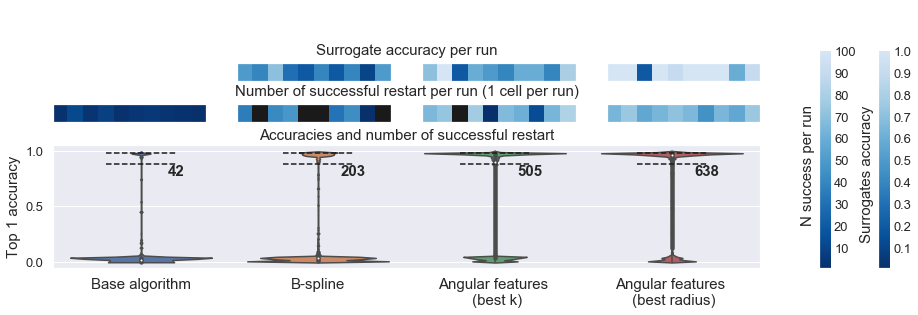

In [103]:
#Fetch useful data
all_exp_data, all_ceil_accs,n_good_per_run = get_useful_data_for_plotting(exp_names,df_all,df_sum)
all_match_accs = get_all_match_accs(exp_names,df_all,df_sum)
#Get outer structure
n_exp = len(exp_names)
#fig, ax_violin, axes_runs, ax_cb = outer_structure(n_exp,bhist=False)
fig, ax_violin, axes_runs, ax_cb , axes_match , ax_cb_match = outer_structure_match(n_exp,bhist=False)
#Plot
plot_violin(ax_violin,exp_names,df_sum,df_all)
cf = get_run_success(axes_runs,n_good_per_run,all_ceil_accs,cb_max_val = cb_max_val)
plot_colorbar(ax_cb,cf,'N success per run',100)
cf_match = plot_cm_match_accs(axes_match,all_match_accs)
plot_colorbar(ax_cb_match,cf_match,'Surrogates accuracy',1)
if show_best_only:
    ax_violin.set_xticklabels(['Base algorithm','B-spline','Angular features \n (best k)','Angular features \n (best radius)'], fontsize=FTSZ_LABEL)
else:
    ax_violin.set_xticklabels(['base','dist','angles k','angles rad','best dist','best angles k','best angles rad'], fontsize=FTSZ_LABEL)
plt.show()

# Plot n good per runs

In [76]:
n_good_per_scen_dist = np.sum(all_n_good_per_run_dist,axis = 1)
# n_good_per_scen_angles_k = np.sum(all_n_good_per_run_angles_k,axis = 1)
# n_good_per_scen_angles_rad = np.sum(all_n_good_per_run_angles_rad,axis = 1)
n_good_per_scen_base = np.sum(all_n_good_per_run_base,axis = 1)
n_good_per_scen_dist_best = np.sum(all_n_good_per_run_dist_best,axis = 1)
n_good_per_scen_angles_k_best = np.sum(all_n_good_per_run_angles_k_best,axis = 1)
n_good_per_scen_angles_rad_best = np.sum(all_n_good_per_run_angles_rad_best,axis = 1)
n_good_per_scen_dist_Ncorr3 = np.sum(all_n_good_per_run_dist_Ncorr3,axis = 1)

In [77]:
print(n_good_per_scen_base)
print(n_good_per_scen_dist_best)
print(n_good_per_scen_angles_k_best)
print(n_good_per_scen_angles_rad_best)

[ 52. 106.  53.  27. 100. 110.  16.  52.   9.   4.   5.   0.   0.  52.
  50.  53.  56.  88.  36.  52.  42.]
[611. 498. 190.  43. 559. 294.  75. 611. 506. 506. 572. 313. 789. 611.
  55. 112. 116. 986. 787. 611. 203.]
[667. 667. 330.  93. 719. 419.  81. 667. 601. 967. 661. 369. 990. 667.
 101.  39. 151. 943. 844. 667. 505.]
[773. 725. 198.  48. 841. 534. 171. 773. 930. 880. 971. 809. 802. 773.
 663. 390. 195. 974. 816. 773. 638.]


In [78]:
dict_new_names['clump'] = flat([['clump1'],["clump%d"%i for i in range(2,8)]])
dict_new_names['clump'] = ['Clump1','Clump2-2','Clump2-4','Clump2-8','Clump3-2','Clump3-4','Clump3-8']
dict_new_names['embdim'] = ['emdim2',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_new_names['noise'] = ['noise1e-3','noise5e-3','noise1e-2','noise2e-2']
dict_new_names['ncon'] = ['ncon50','ncon100','ncon200','ncon300']
exceptions = ['all'] 
all_labels = []
for key in dict_file_names:    
    if key not in exceptions:
        all_labels.append(dict_new_names[key])
all_labels = flat(all_labels)   

In [79]:
print(all_labels)

['Clump1', 'Clump2-2', 'Clump2-4', 'Clump2-8', 'Clump3-2', 'Clump3-4', 'Clump3-8', 'emdim2', 'embdim3', 'embdim4', 'embdim5', 'embdim7', 'embdim10', 'noise1e-3', 'noise5e-3', 'noise1e-2', 'noise2e-2', 'ncon50', 'ncon100', 'ncon200', 'ncon300']


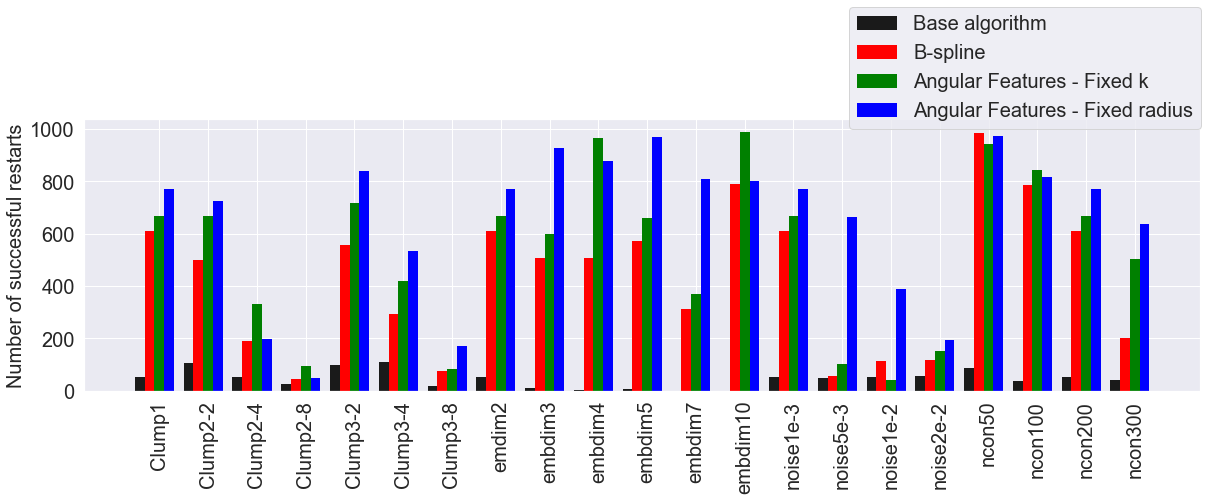

In [46]:
x = np.arange(len(all_labels))
w = 0.2

fig, ax = plt.subplots(figsize = (20,5))
ax.bar(x- 2*w, n_good_per_scen_base, w, color='k', label='Base algorithm',linewidth=0)
ax.bar(x-w, n_good_per_scen_dist_best, w, color='red', label='B-spline',linewidth=0)
ax.bar(x , n_good_per_scen_angles_k_best, w, color='green', label='Angular Features - Fixed k',linewidth=0)
ax.bar(x + w, n_good_per_scen_angles_rad_best, w, color='blue', label='Angular Features - Fixed radius',linewidth=0)

ax.xaxis.set_ticks(x)
ax.set_xticklabels(all_labels, rotation= 90,fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylabel('Number of successful restarts',fontsize=20)
ax.legend()

plt.legend(loc="upper right",bbox_to_anchor=(1.01, 1.45),fontsize = 20)
plt.show()

In [135]:
# #PLOT
# n_runs = 10
# from matplotlib import cm
# x = np.arange(len(all_labels))
# colors = [cm.Dark2(i) for i in np.linspace(0, 1, n_runs)]
# w = 0.2
# fig = plt.figure(figsize = (15,5)) 
# for i in range(n_runs):
#     plt.bar(x - 3*w/2,all_n_good_per_run_base[:,i], w,bottom=np.sum(all_n_good_per_run_base[:,:i],axis=1),linewidth=0,color =colors[i])
#     plt.bar(x-w/2,all_n_good_per_run_dist_best[:,i], w,bottom=np.sum(all_n_good_per_run_dist_best[:,:i],axis=1),label = 'run %d'%(i+1),linewidth=0,color =colors[i] )
#     plt.bar(x + w/2,all_n_good_per_run_angles_k_best[:,i], w,bottom=np.sum(all_n_good_per_run_angles_k_best[:,:i],axis=1),linewidth=0,color =colors[i])
#     plt.bar(x + 3*w/2,all_n_good_per_run_angles_rad_best[:,i], w,bottom=np.sum(all_n_good_per_run_angles_rad_best[:,:i],axis=1),linewidth=0,color =colors[i])
#     plt.xticks(x,labels= all_labels,rotation=90,fontsize=14)
# plt.legend(loc="upper right",bbox_to_anchor=(1.07, 1.015))
# plt.show()

# N correlation

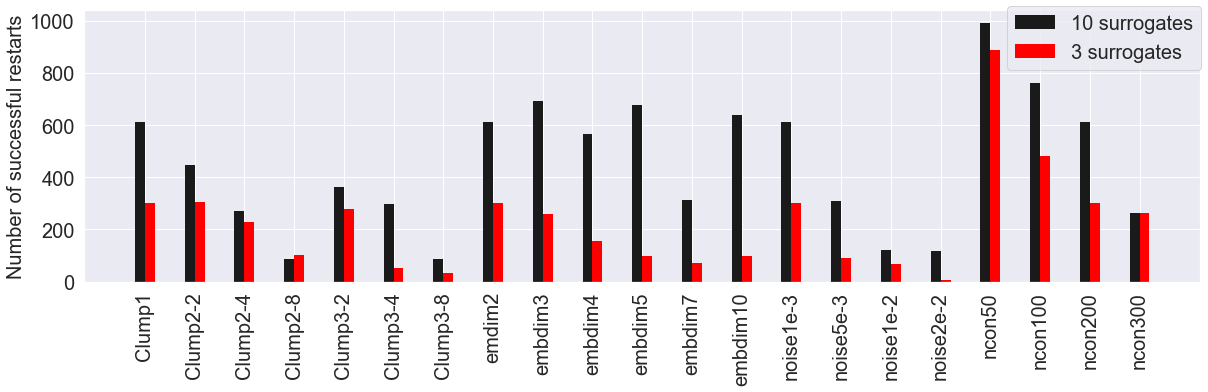

In [80]:
x = np.arange(len(all_labels))
w = 0.2

fig, ax = plt.subplots(figsize = (20,5))
ax.bar(x-w/2, n_good_per_scen_dist, w, color='k', label='10 surrogates',linewidth=0)
ax.bar(x+w/2, n_good_per_scen_dist_Ncorr3, w, color='red', label='3 surrogates',linewidth=0)

ax.xaxis.set_ticks(x)
ax.set_xticklabels(all_labels, rotation= 90,fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylabel('Number of successful restarts',fontsize=20)
ax.legend()

plt.legend(loc="upper right",bbox_to_anchor=(1.01, 1.05),fontsize = 20)
plt.show()

# Matches accuracy vs success rate

In [263]:
def find_scen_index(scen,all_labels):
    i = 0
    for l in all_labels:
        print(scen in l)
        if scen in l:
            j = l.index(scen)
            break
        else:
            i +=1
    return i,j
def get_subset(exps,exp_list,all_n_good_per_run,all_matches_acc):
    idxs = [exp_list.index(e) for e in exps]
    sub_n_good_per_run = [all_n_good_per_run[i] for i in idxs] #np.concatenate(all_n_good_per_run,axis = 0)[idxs].reshape(-1)
    sub_matches_acc = [all_matches_acc[i] for i in idxs] # np.concatenate(all_matches_acc,axis = 0)[idxs].reshape(-1)
    return sub_matches_acc,sub_n_good_per_run

In [301]:
dict_new_names = {}
dict_new_names['clump'] = flat([['clump1'],["clump%d"%i for i in range(2,8)]])
dict_new_names['embdim'] = ['emdim2',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_new_names['noise'] = ['noise1e-3','noise5e-3','noise1e-2','noise2e-2']
dict_new_names['ncon'] = ['ncon50','ncon100','ncon200','ncon300']
exceptions = ['all'] 
all_labels = []
for key in dict_file_names:    
    if key not in exceptions:
        all_labels.append(dict_new_names[key])
# all_labels = flat(all_labels)   
exp_list = list(dict_new_names)
# print(dict_new_names)
print(exp_list)

['clump', 'embdim', 'noise', 'ncon']


In [302]:
all_n_good_per_run = all_n_good_per_run_dist_best
all_all_matches_acc = all_all_match_accs_dist_best
#transform in list of list 
all_n_good_per_run = [all_n_good_per_run[:7],all_n_good_per_run[7:13],all_n_good_per_run[13:17],all_n_good_per_run[17:]]
all_all_matches_acc = [all_all_matches_acc[:7],all_all_matches_acc[7:13],all_all_matches_acc[13:17],all_all_matches_acc[17:]]

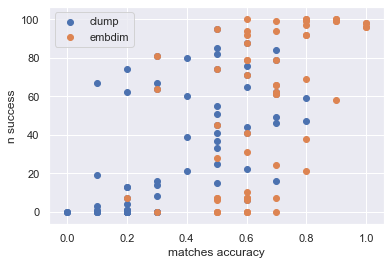

In [303]:
exp_list = list(dict_file_names)
exps = ['clump','embdim']
sub_matches_acc,sub_n_good_per_run = get_subset(exps,exp_list,all_n_good_per_run,all_all_matches_acc)
for i,(m,s) in enumerate(zip(sub_matches_acc,sub_n_good_per_run)): 
    plt.scatter(m,s,label = exps[i])
plt.xlabel('matches accuracy')
plt.ylabel('n success')
plt.legend()

[['clump1', 'clump2', 'clump3', 'clump4', 'clump5', 'clump6', 'clump7'], ['emdim2', 'embdim3', 'embdim4', 'embdim5', 'embdim7', 'embdim10'], ['noise1e-3', 'noise5e-3', 'noise1e-2', 'noise2e-2'], ['ncon50', 'ncon100', 'ncon200', 'ncon300']]


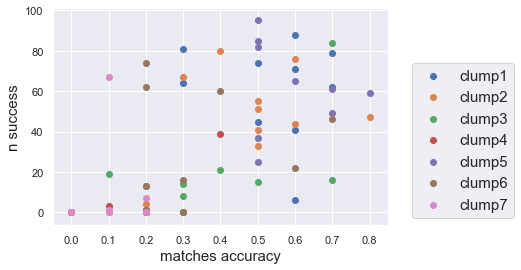

In [314]:
exp = ['clump']
labels = all_labels[exp_list.index(exp[0])]
print(all_labels)
sub_matches_acc,sub_n_good_per_run = get_subset(exp,exp_list,all_n_good_per_run,all_all_matches_acc)
matches_acc,n_good_per_run = sub_matches_acc[0],sub_n_good_per_run[0]
n_scen = matches_acc.shape[0]
for i in range(n_scen): 
    m,s = matches_acc[i],n_good_per_run[i]
    plt.scatter(m,s,label = labels[i])
plt.xlabel('matches accuracy',fontsize = 15)
plt.ylabel('n success',fontsize = 15)
plt.legend(loc="lower right",bbox_to_anchor=(1.4, 0),fontsize = 15)

True
0 6


Text(0, 0.5, 'n success')

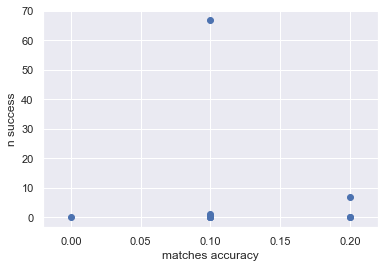

In [315]:
scen = 'clump7'
i,j = find_scen_index(scen,all_labels)
print(i,j)
matches_acc = all_all_matches_acc[i][j]
n_good_per_run = all_n_good_per_run[i][j]
plt.scatter(matches_acc,n_good_per_run)
plt.xlabel('matches accuracy')
plt.ylabel('n success')

# Compare between methods

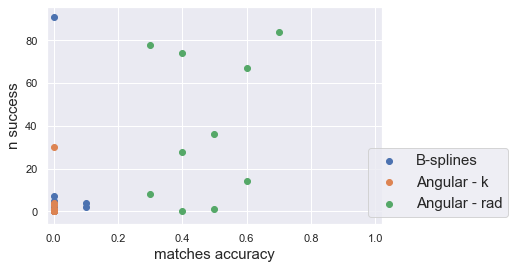

In [332]:
scen = "noise1e-2"
flat_all_labels = flat(all_labels) 
idx = flat_all_labels.index(scen)
list_n_good = [all_n_good_per_run_dist_best[idx],all_n_good_per_run_angles_k_best[idx],all_n_good_per_run_angles_rad_best[idx]]
list_n_match = [all_all_match_accs_dist_best[idx],all_all_match_accs_angles_k_best[idx],all_all_match_accs_angles_rad_best[idx]]
labs = ['B-splines','Angular - k', 'Angular - rad']
for i in range(3): 
    m,s = list_n_match[i],list_n_good[i]
    plt.scatter(m,s,label = labs[i])
plt.xlim(-0.02,1.02)
plt.xlabel('matches accuracy',fontsize = 15)
plt.ylabel('n success',fontsize = 15)
plt.legend(loc="lower right",bbox_to_anchor=(1.4, 0),fontsize = 15)

# All all

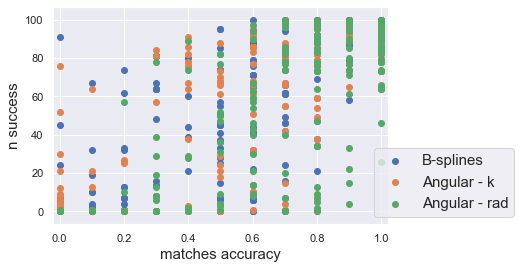

In [333]:
scen = "noise1e-2"
flat_all_labels = flat(all_labels) 
list_n_good = [all_n_good_per_run_dist_best,all_n_good_per_run_angles_k_best,all_n_good_per_run_angles_rad_best]
list_n_match = [all_all_match_accs_dist_best,all_all_match_accs_angles_k_best,all_all_match_accs_angles_rad_best]
labs = ['B-splines','Angular - k', 'Angular - rad']
for i in range(3): 
    m,s = list_n_match[i],list_n_good[i]
    plt.scatter(m,s,label = labs[i])
plt.xlim(-0.02,1.02)
plt.xlabel('matches accuracy',fontsize = 15)
plt.ylabel('n success',fontsize = 15)
plt.legend(loc="lower right",bbox_to_anchor=(1.4, 0),fontsize = 15)